# Tagup Data Science Exercise

ExampleCo, Inc is gathering several types of data for its fleet of very expensive machines.  These very expensive machines have three operating modes: *normal*, *faulty* and *failed*.   The machines run all the time, and usually they are in normal mode.  However, in the event that the machine enters faulty mode, the company would like to be aware of this as soon as possible.  This way they can take preventative action to avoid entering failed mode and hopefully save themselves lots of money.

They collect four kinds of timeseries data for each machine in their fleet of very expensive machines.  When a machine is operating in *normal* mode the data behaves in a fairly predictable way, but with a moderate amount of noise.  Before a machine fails it will ramp into *faulty* mode, during which the data appears visibly quite different.  Finally, when a machine fails it enters a third, and distinctly different, *failed* mode where all signals are very close to 0.

You can download the data here: [exampleco_data](https://drive.google.com/open?id=1b12u6rzkG1AxB6wLGl7IBVoaoSoZLHNR)

## Objectives 

1. **Your primary objective is to develop an approach to detect the beginning of the “faulty” period**. Ideally, this approach would give the ExampleCo engineers as much time as possible to shut down their machines before failure occurs (at which time all measurements drop close to 0). The best solutions are automated in the sense that they would generalize to similar but slightly different data; simpler methods are acceptable but are less likely to receive full credit.
2. Demonstrate the efficacy of your approach using visualizations. You must also include a simple explanation of these figures and why your approach is effective, ideally written in language that non-technical executives could understand.
3. Finally, and now with a technical audience in mind, discuss the strengths and limitations of your approach and be sure to mention other approaches that you would have liked to try if you had more time.


## Notes to help
1. A good place to start is by addressing the noise due to communication
   errors.
2. Feel free to use any libraries you like. Your final results should be
   presented in this Python notebook.
3. There are no constraints on the techniques you bring to bear, we are curious
   to see how you think and what sort of resources you have in your toolbox.
4. **Be sure to clearly articulate what you did, why you did it, and how the
   results should be interpreted**. In particular, you should be aware of the
   limitations of whatever approach or approaches you take.
5. Don't feel compelled to use all the data if you're not sure how. Feel free
   to focus on data from a single unit if that makes it easier to get started.
6. Don't hesitate to reach out to datasciencejobs@tagup.io with any questions!

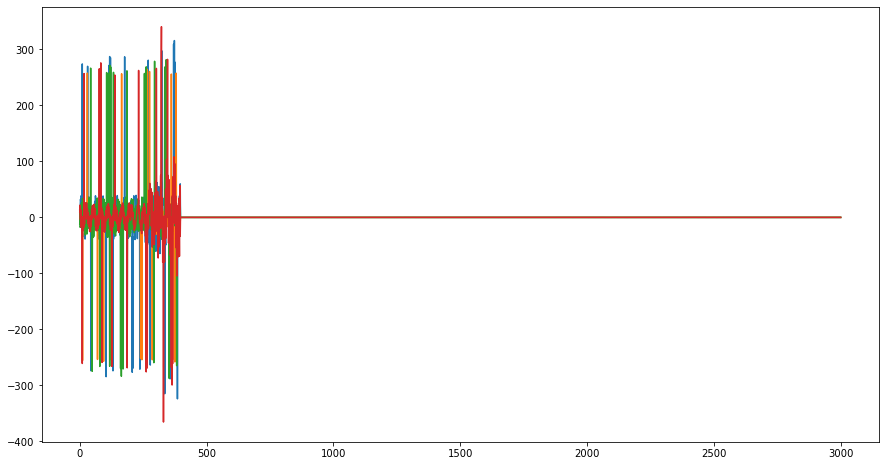

In [4]:
# To help you get started...
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 


data = pd.read_csv('../exampleco_data/machine_0.csv',index_col=0)
fig = plt.figure(figsize=(15,8))
d =  data.applymap(lambda x: 0 if abs(round(x, 0)) == 250 else x)
plt.plot(range(len(d)), d, figure = fig)
plt.show()

### Handle the noise

1) Filtered noise based on a threshold value determined via visual inspection of the data. Although this is a limited method in terms of reliance on user input/static value it proved the most effective of the noise filtering techniques tested. Given the problem set up, it also seemed quite reasonable to be able to set a threshold value like this.

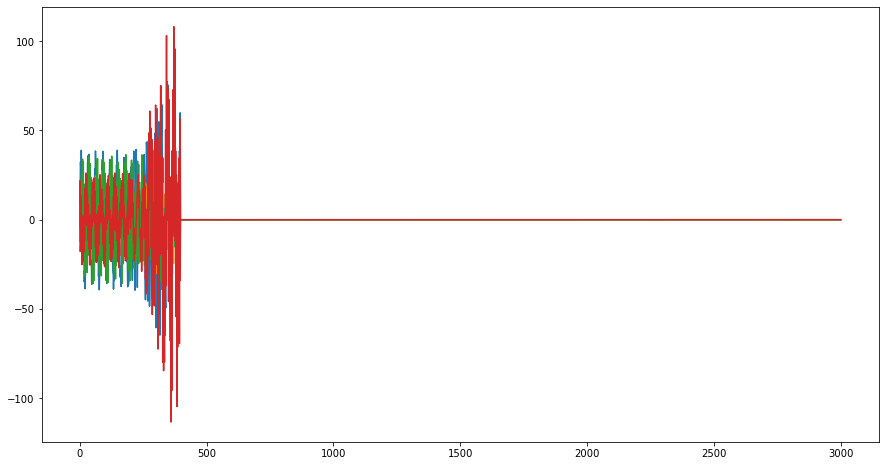

In [5]:
def threshold_denoiser(data, threshold=250):
    d =  data.applymap(lambda x: np.nan if abs(round(x, 0)) >= threshold else x)
    d = d.fillna(method='bfill')
    return d
d = threshold_denoiser(data)
fig = plt.figure(figsize=(15,8))
plt.plot(range(len(d)), d, figure = fig)
plt.show()

2) Tested a simple filter based on number of standard deviations from the mean (calculated via moving average). After testing multiple sizes of rolling windows and thresholds (different numbers of standard deviations from the mean), concluded that the results were unsatisfactory in removing the visually obvious noise.

In [6]:
def denoiser(data):
    d = data.copy()
    ma = data.fillna(method='bfill').rolling(20).mean().fillna(method='bfill')
    std = data.fillna(method='bfill').rolling(20).mean().fillna(method='bfill')
    max_vals = ma.add(3*std)
    min_vals = ma.add(-3*std)
    for col in d.columns:
        d[col] = np.where((min_vals[col] < d[col]) & (max_vals[col] > d[col]), d[col], np.nan)
    return d.fillna(method='bfill')

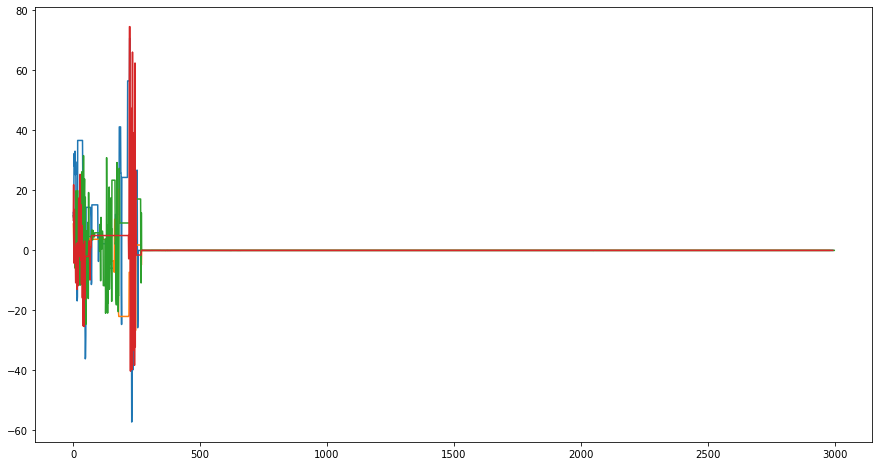

In [7]:
data = pd.read_csv('../exampleco_data/machine_11.csv',index_col=0)
d = denoiser(data)
fig = plt.figure(figsize=(15,8))
plt.plot(range(len(d)), d, figure = fig)
plt.show()

3) Tested fitting a least squares line and removing points that deviated largely from the line. Testing revealed that this worked resonably well for some of the data sets, but failed to be effective for others.

In [ ]:
def linear_denoiser(x_vals, y_vals, next_x, next_y, threshold=4):
    x = np.vstack([x_vals, np.ones(len(x_vals))]).T
    m,c = np.linalg.lstsq(x, y_vals, rcond=None)[0]
    pred_y = m*next_x + c
    pred_ys = m*x_vals + c
    resid = np.sqrt((pred_y-next_y)**2)
    if resid > threshold * np.mean(np.sqrt((pred_ys - y_vals)**2)):
        return np.nan
    else:
        return next_y
def linear_denoiser_start(x_vals, y_vals, threshold = 4):
    x = np.vstack([x_vals, np.ones(len(x_vals))]).T
    m,c = np.linalg.lstsq(x, y_vals, rcond=None)[0]
    pred_ys = m*x_vals + c
    resid = list(np.sqrt((pred_ys-y_vals)**2))
    mean_resid = np.mean(resid)
    return [y_vals[i] if y_vals[i] < threshold * mean_resid else np.nan for i in range(len(y_vals))]
    
def apply_linear_denoiser(data, starter = 20, threshold = 4):
    d = data.copy()
    x = np.array(range(len(data)))
    for col in data.columns:
        y_vals = [float(y) for y in list(data[col])]
        d[col] = linear_denoiser_start(x[:starter+1],y_vals[:starter+1], threshold=threshold) + [linear_denoiser(x[:i], y_vals[:i], x[i+1], y_vals[i+1], threshold=threshold) for i in range(starter,len(data)-1)]
    return d.fillna(method='bfill')

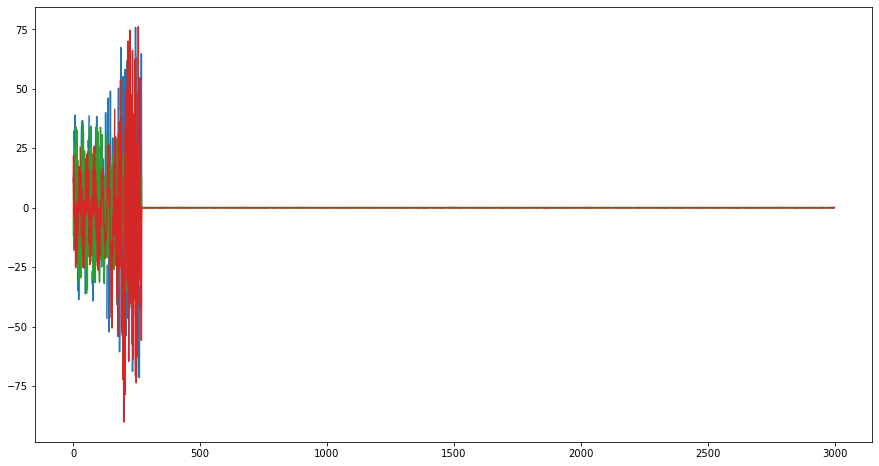

In [20]:
d = apply_linear_denoiser(data)
fig = plt.figure(figsize=(15,8))
plt.plot(range(len(d)), d, figure = fig)
plt.show()

### Examine Data for Patterns

Visual inspection of the data indicates that the faulty section of the data can be characterized by wider range of values -- which means a larger variance. To test whether standard deviation could be an effective indicator I plotted the rolling standard deviation of the data -- as shown in the graphs below. Visual inspection clearly shows larger standard deviation values at the onset of the faulty period, followed by standard deviation values close to zero during the failure period. In a few instances it looks like the there is no characteristic faulty period and the data seems to drop straight into failure mode. Given the clear pattern, it's evident that the rolling standard deviations are a reasonable indicator of the machines entering into faulty mode.

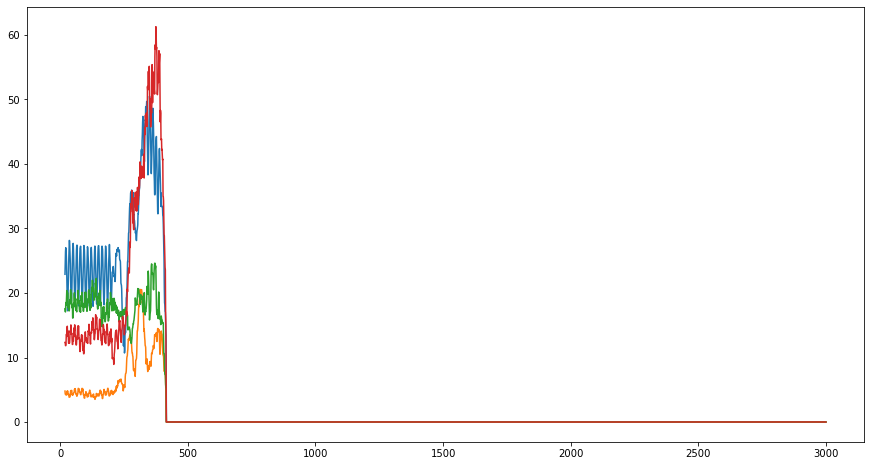

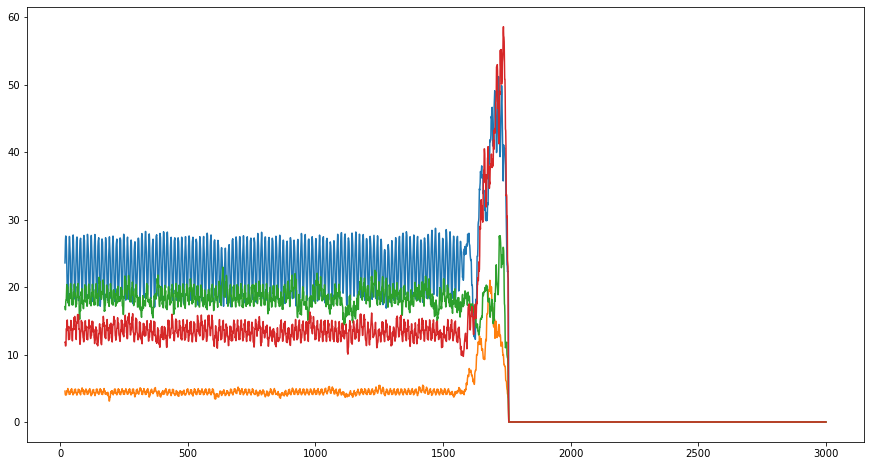

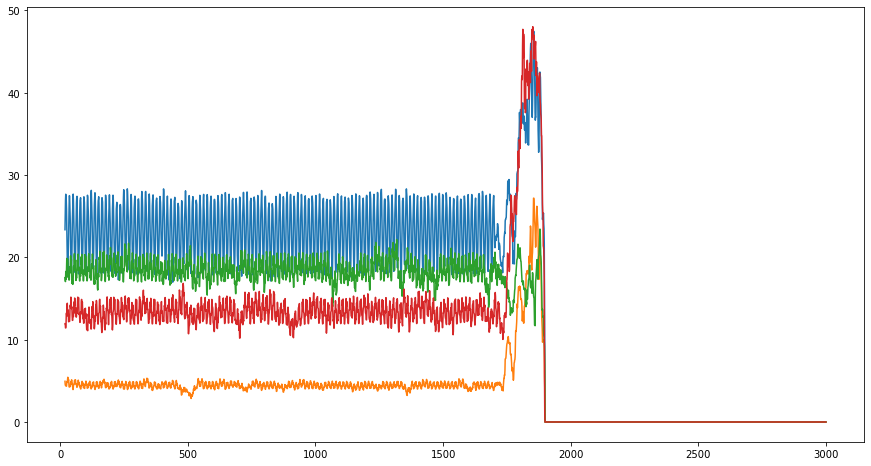

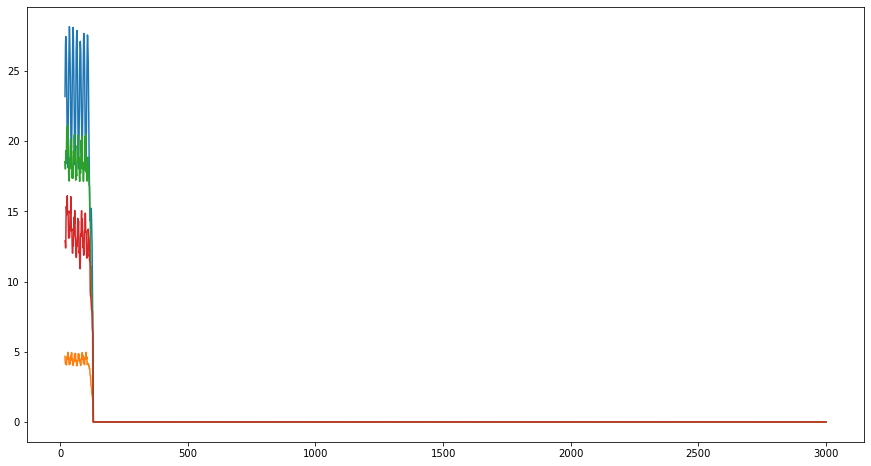

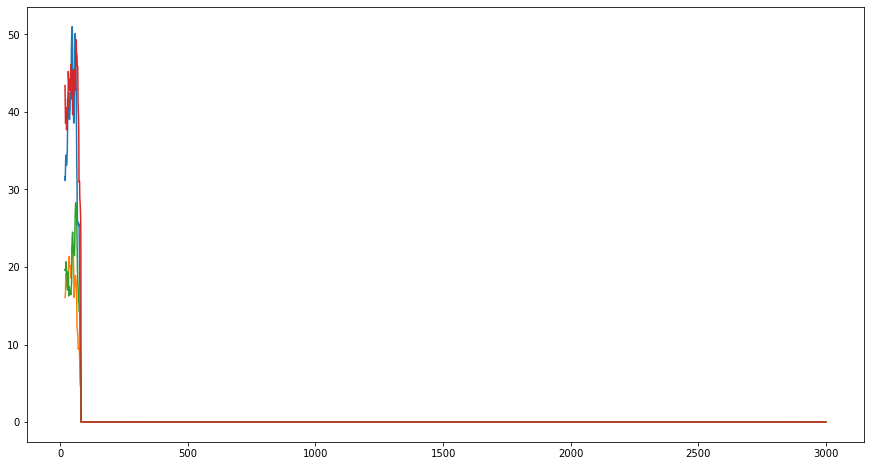

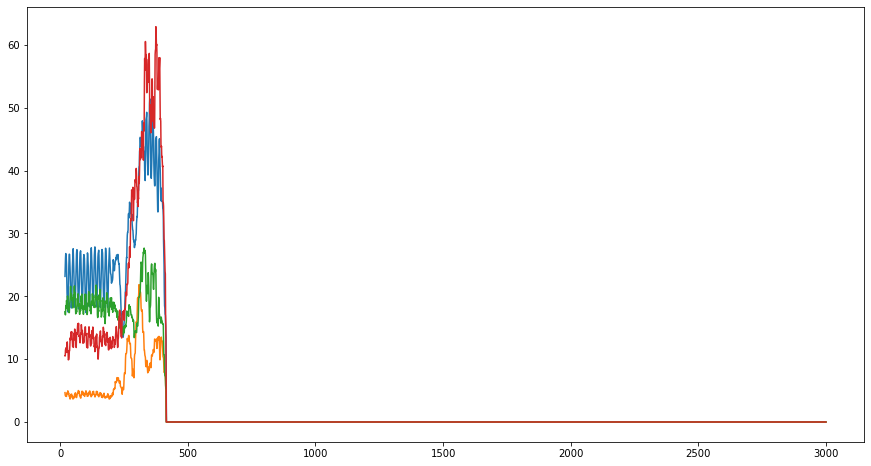

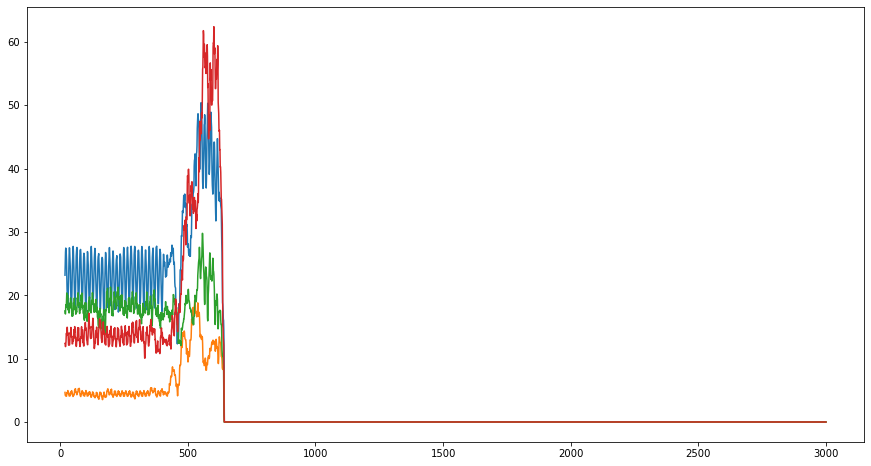

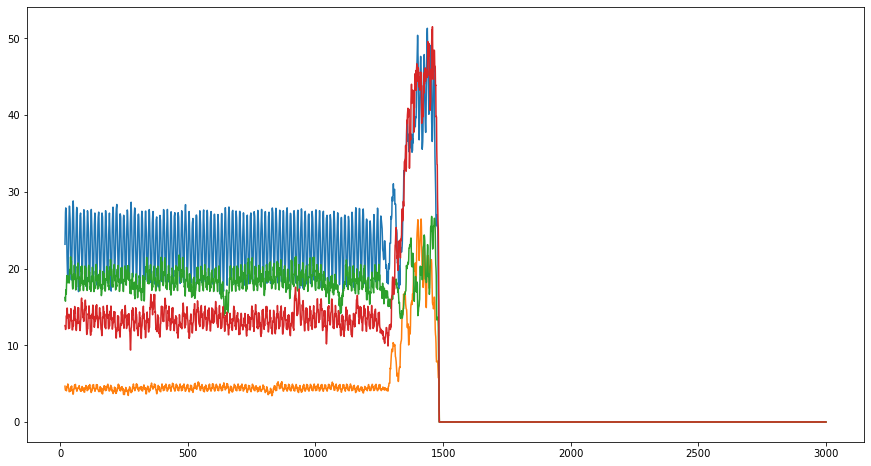

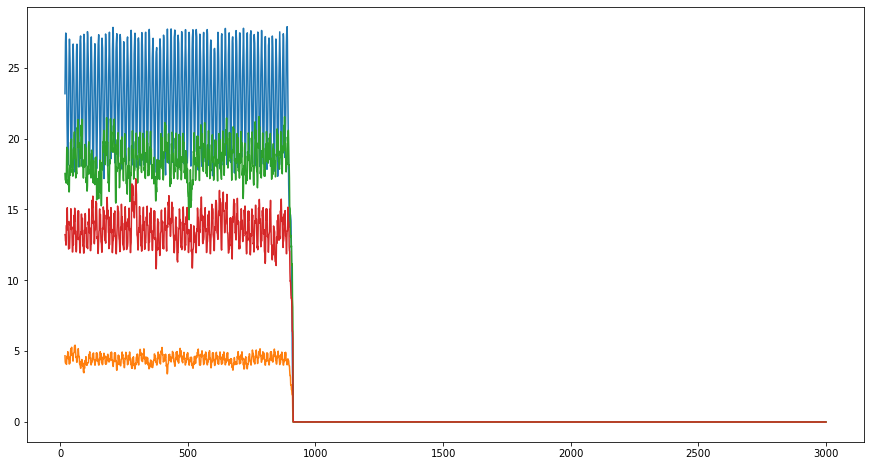

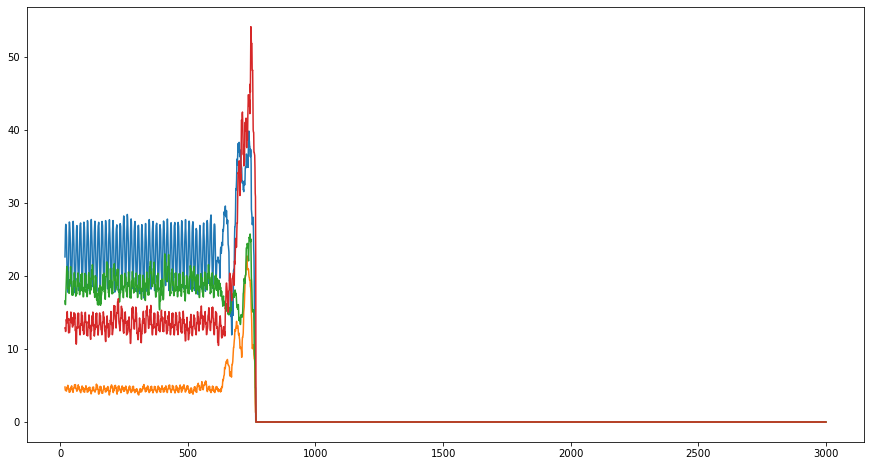

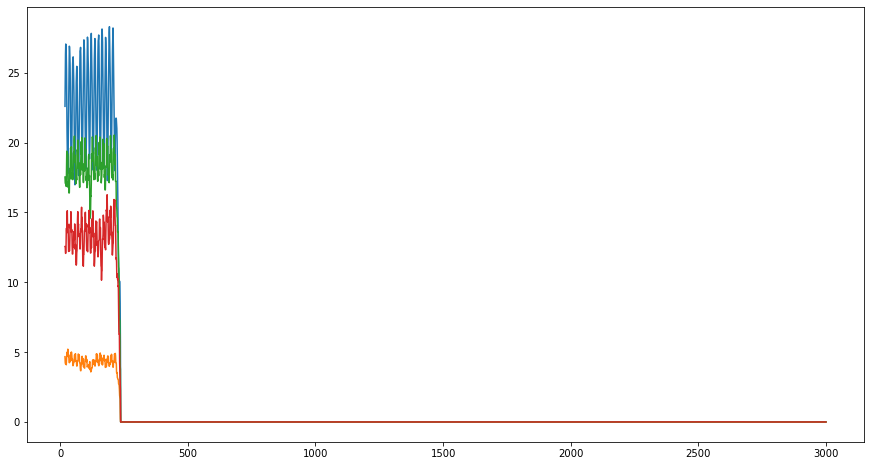

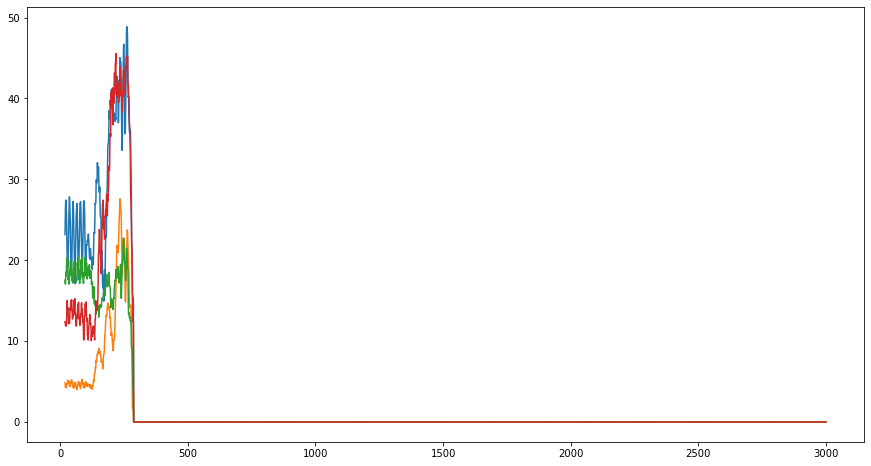

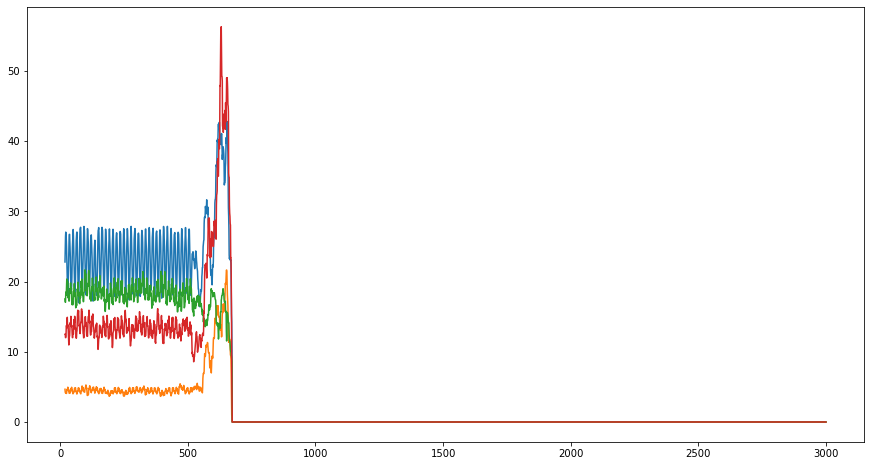

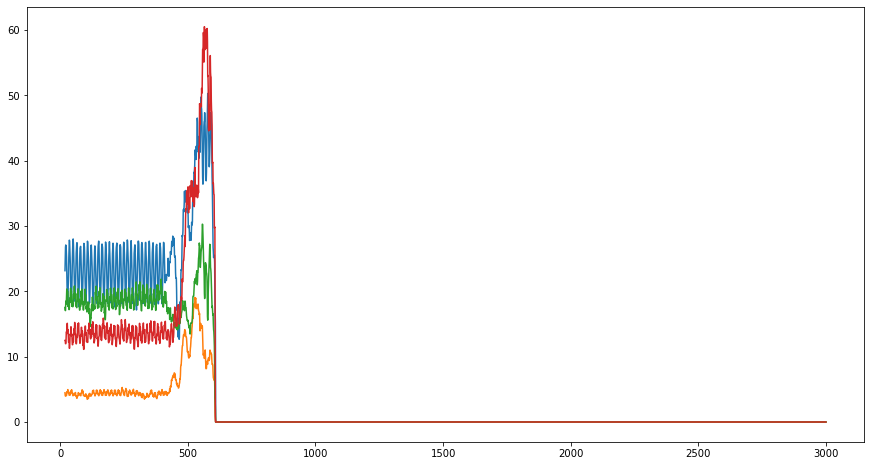

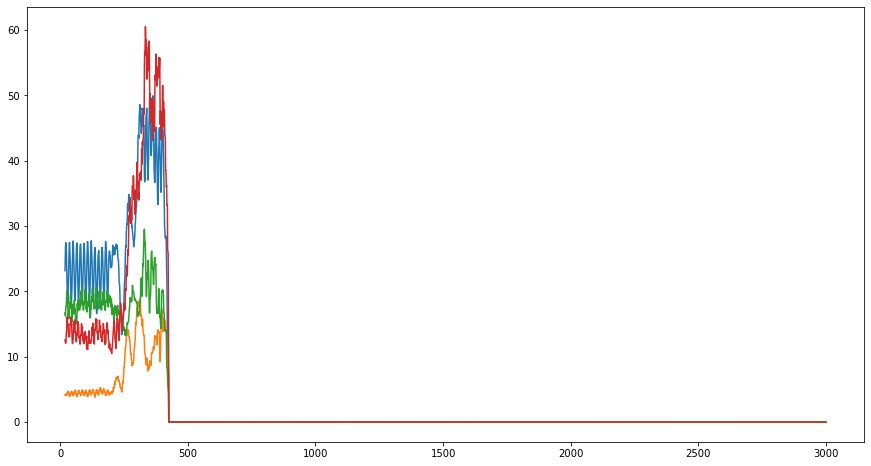

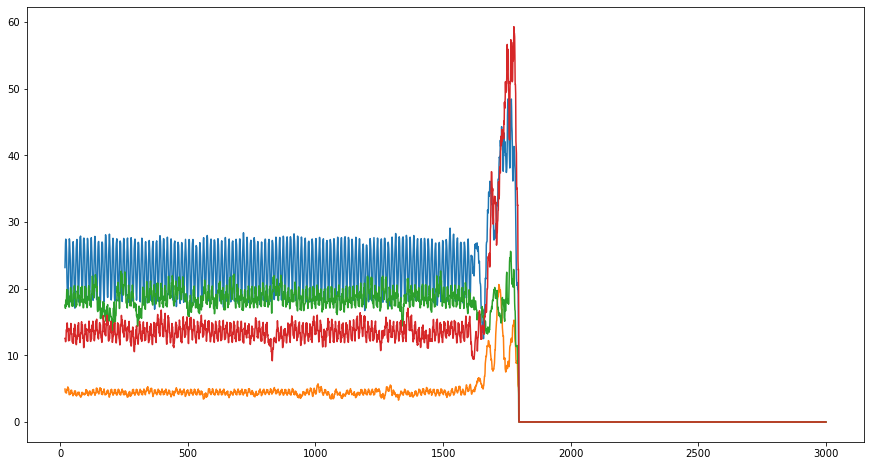

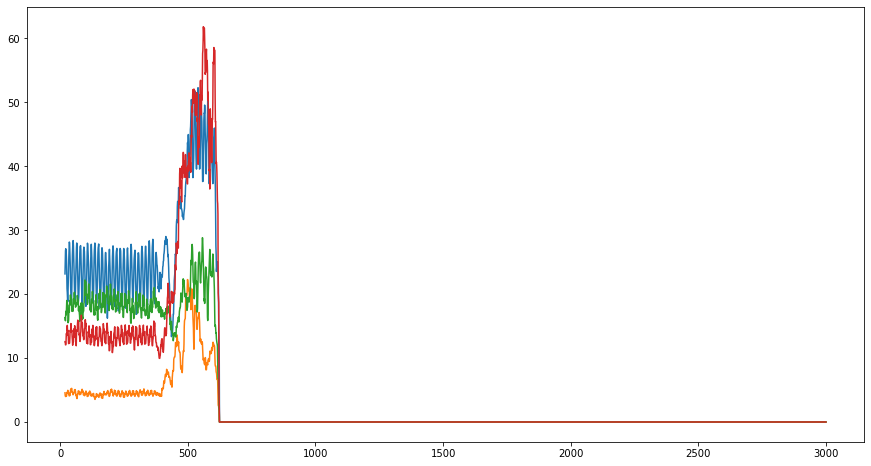

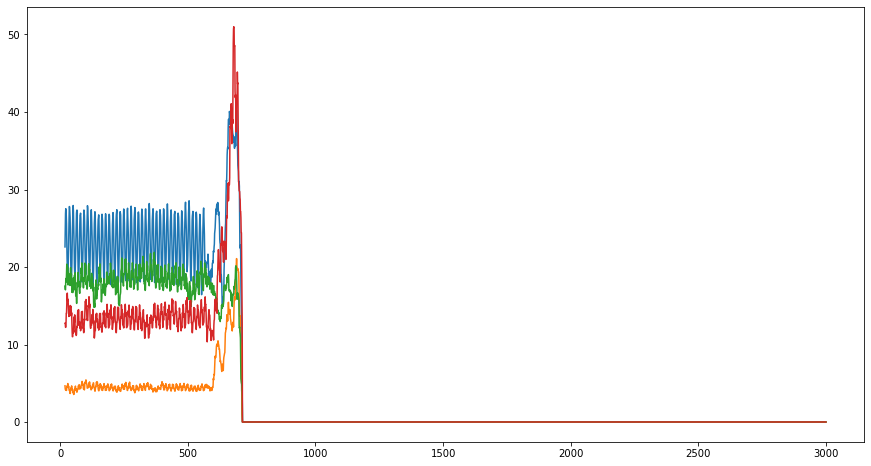

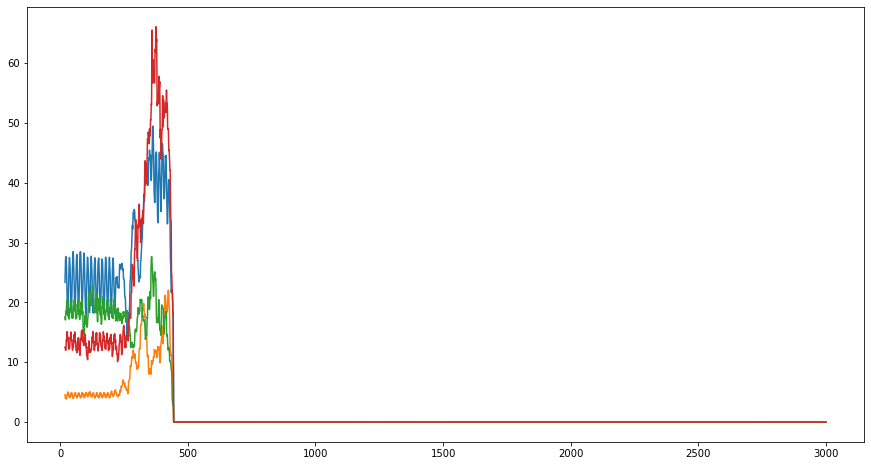

In [24]:
for r in range(19):
    data = pd.read_csv('../exampleco_data/machine_'+str(r)+'.csv',index_col=0)
    d =  threshold_denoiser(data)
    r = d.rolling(20).std()
    fig = plt.figure(figsize=(15,8))
    plt.plot(range(3000), r, figure = fig)

### Results

In [26]:
def machine_faulty(data):
    r = d.rolling(5).std()
    running_vals = {'0':list(r['0']), '1':list(r['1']), '2':list(r['2']), '3':list(r['3'])}
    for i in range(6,len(r)-1):
        std_increase = 0
        for v in ['0', '1', '2', '3']:
            mean = np.nanmean(running_vals[v][:i-1])
            std = np.nanstd(running_vals[v][:i-1])
            if running_vals[v][i] > mean + std:
                std_increase += 1
            elif round(running_vals[v][i]) == 0:
                std_increase +=1
        if std_increase == 4:
            return i, list(r.index)[i]
    return None, None

#### Non-technical Explanation
The diagrams below show the time series produced by each of the 20 machines. The black line indicates the point at which the algorithm detected that the machine entered faulty mode, based on the previous data points. The algorithm works by first removing outlying points caused by communication errors based on whether the points exceed a threshold value. It then tracks changes in the range of values in each time series and when this range values significantly deviates from that of the previous range the algorithm flags the machine as entering faulty mode. This is effective since the range of values in each timeseries usually increases drastically prior to falling to near zero in failure mode. As a failsafe, the algorithm also indicates when the range of values drops to near zero, to account for instances where the faulty mode is very short or skipped altogether.

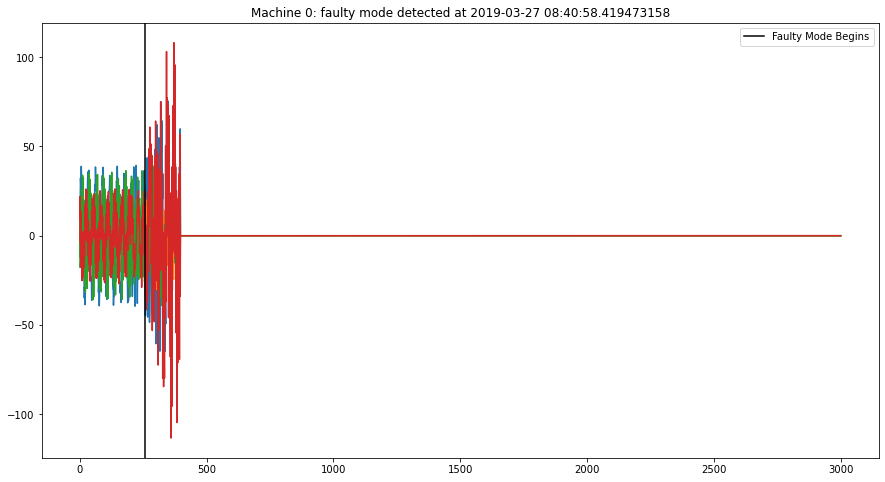

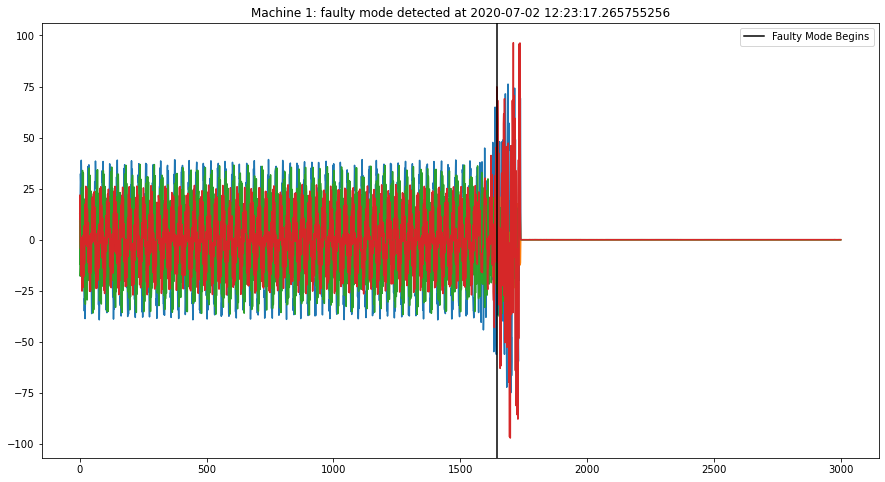

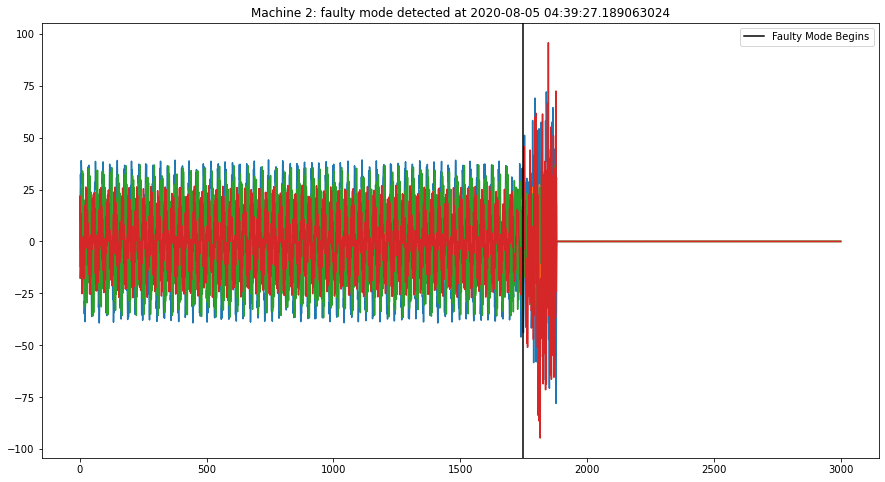

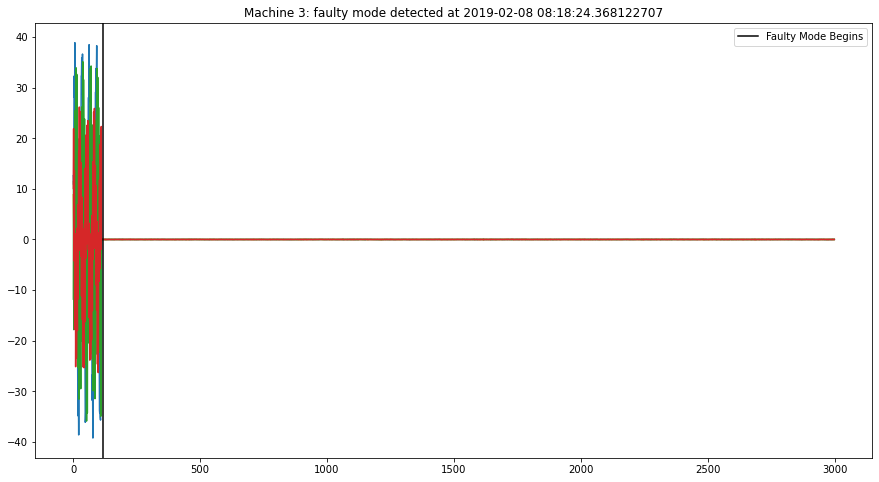

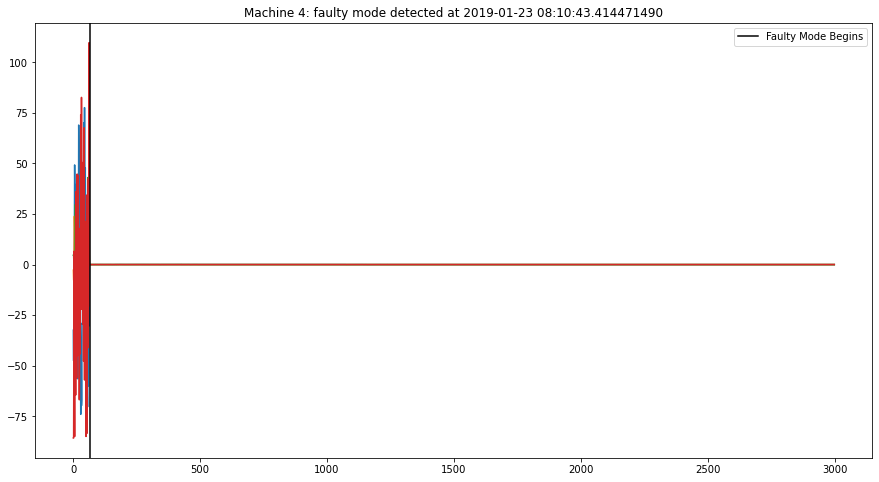

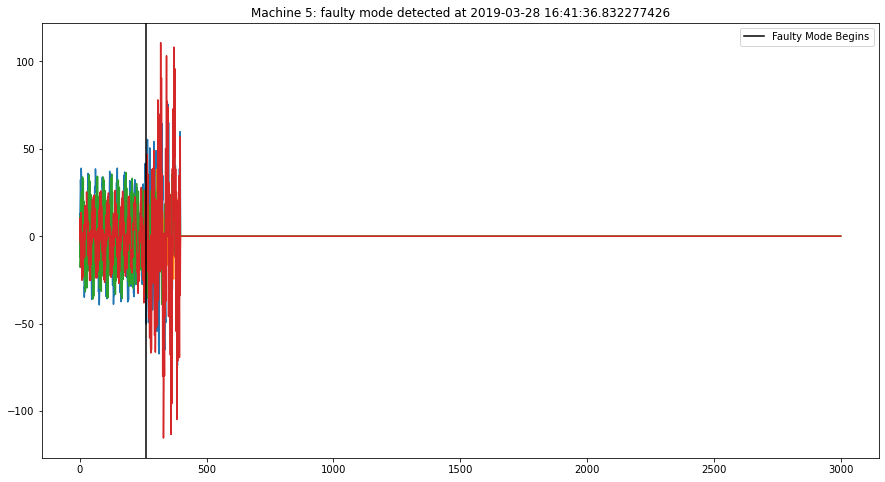

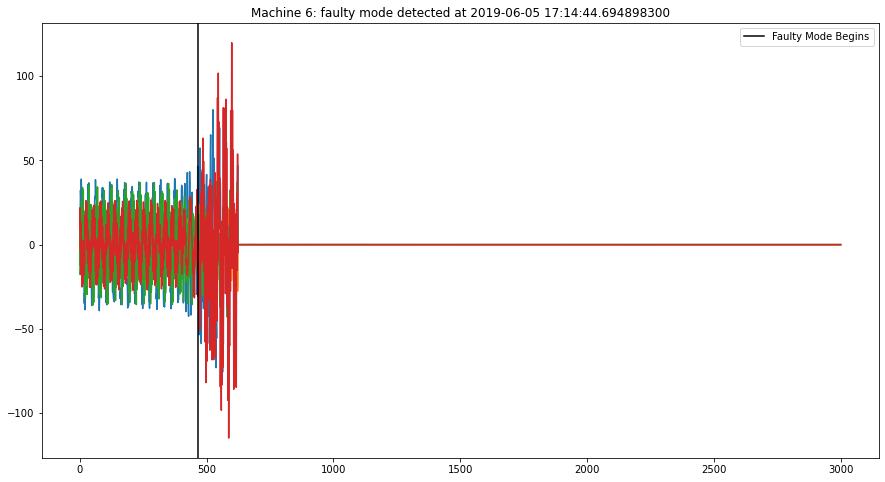

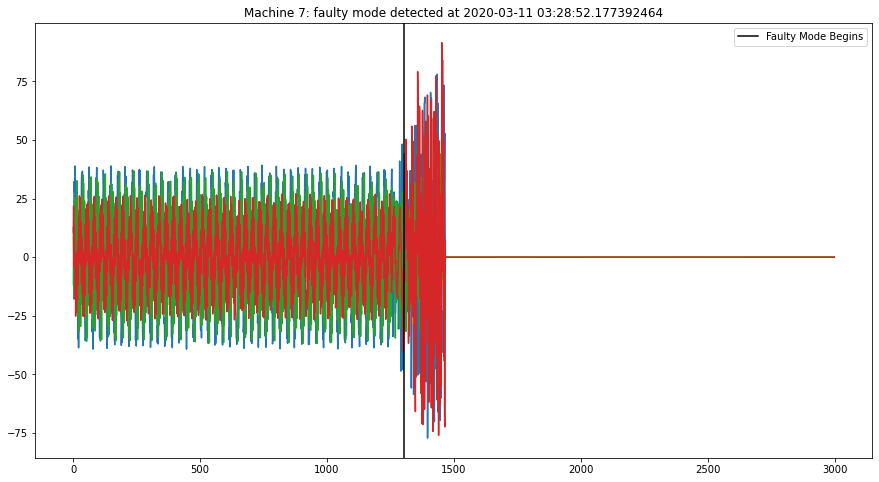

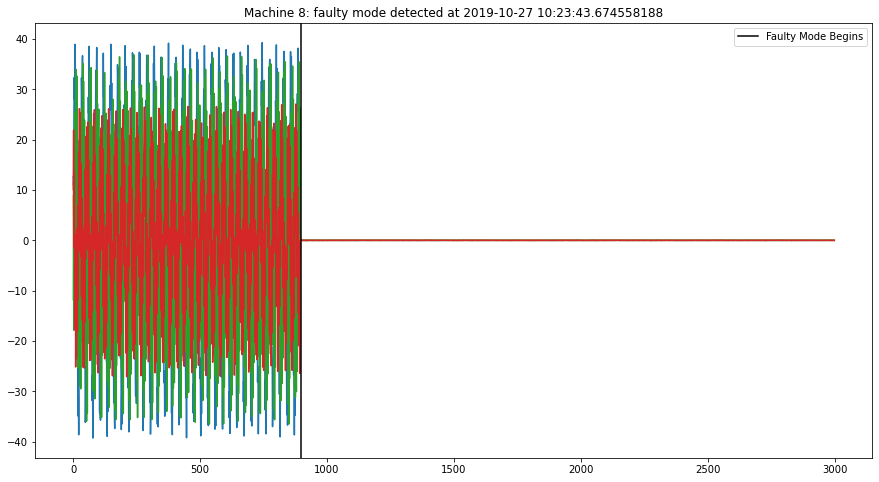

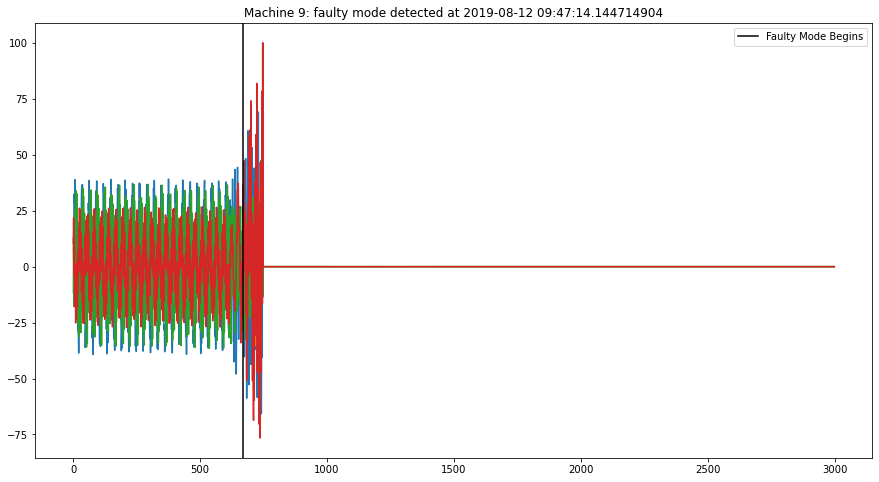

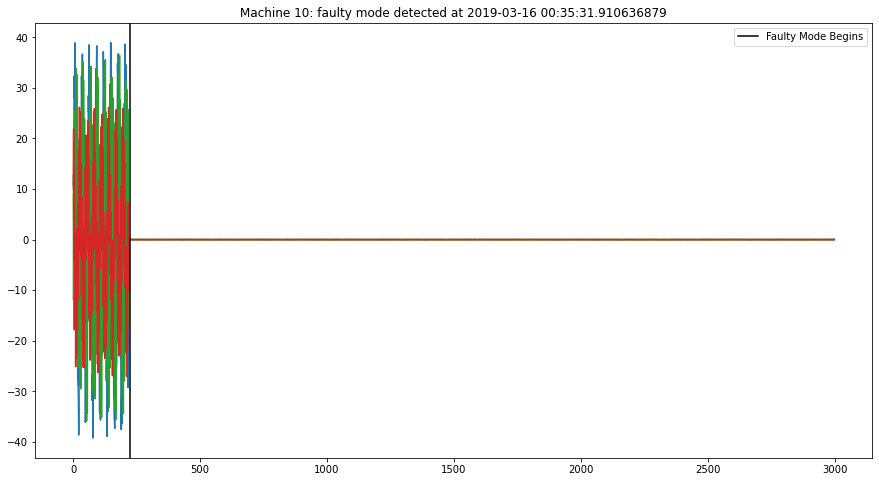

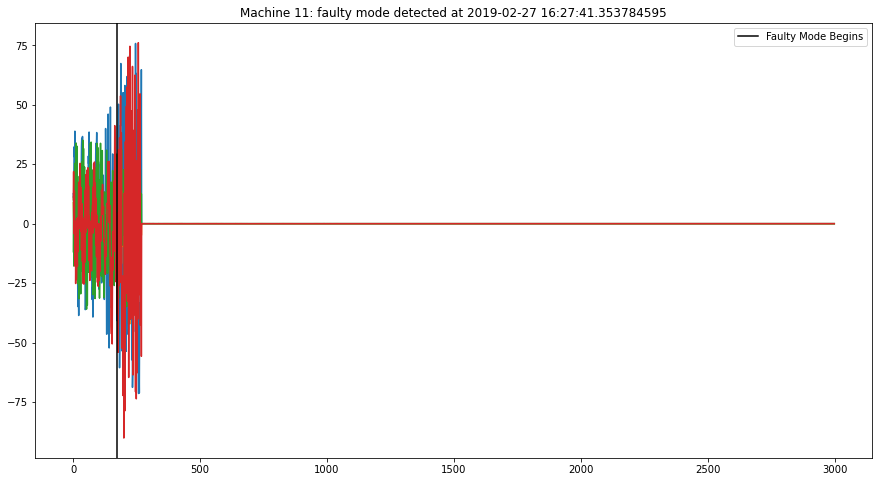

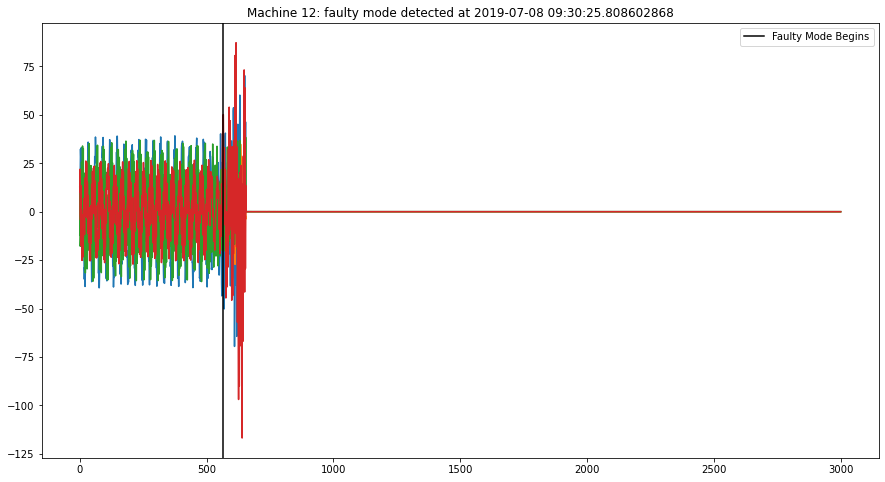

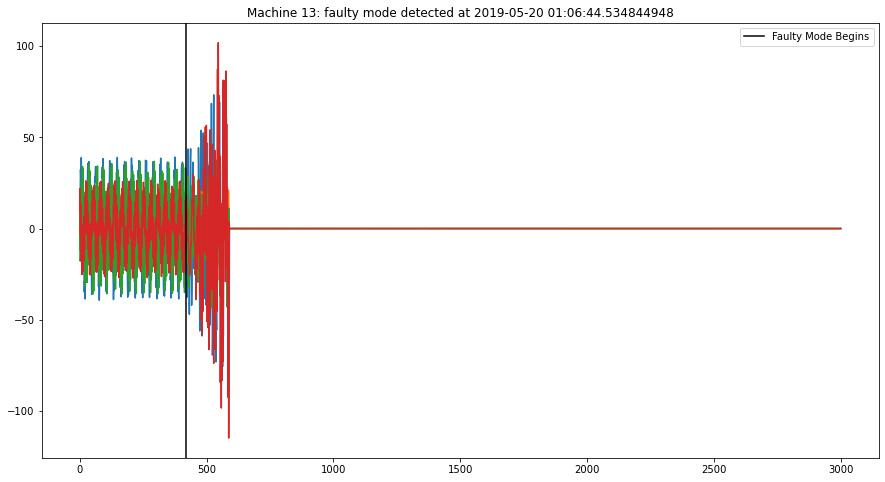

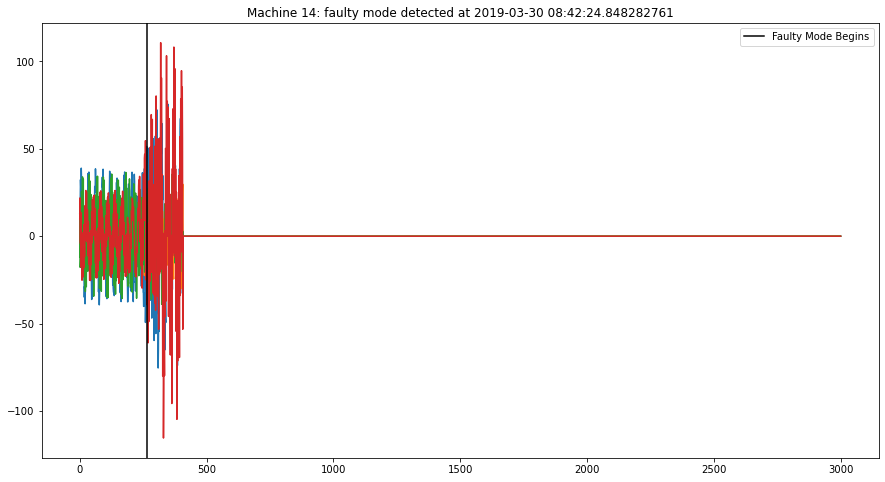

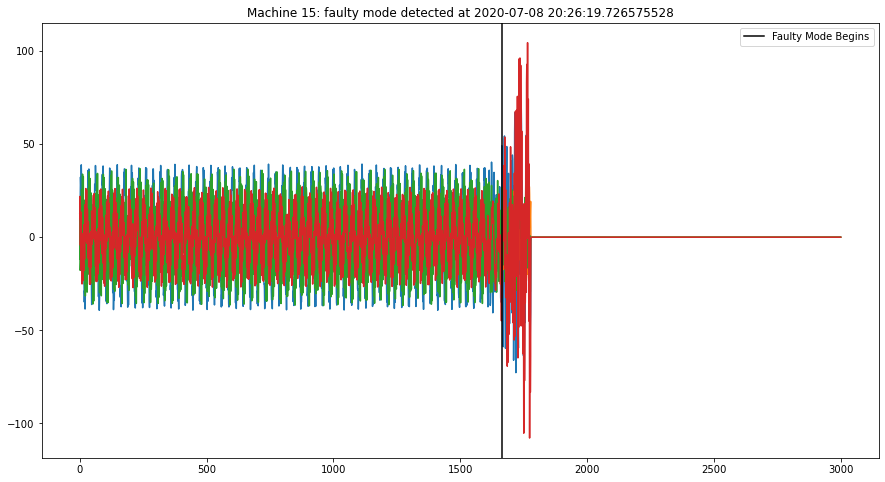

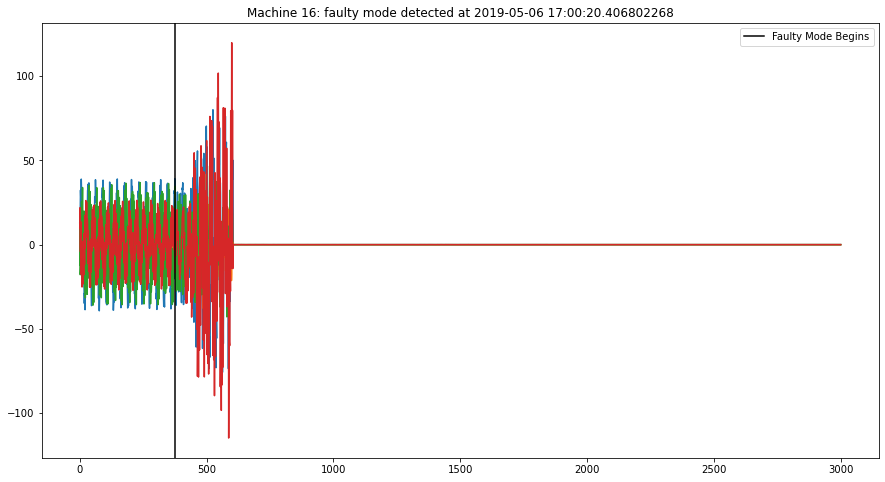

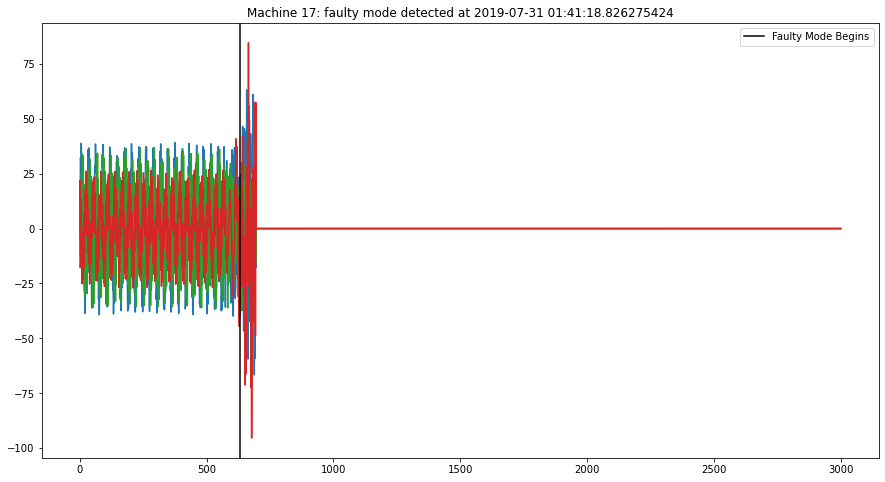

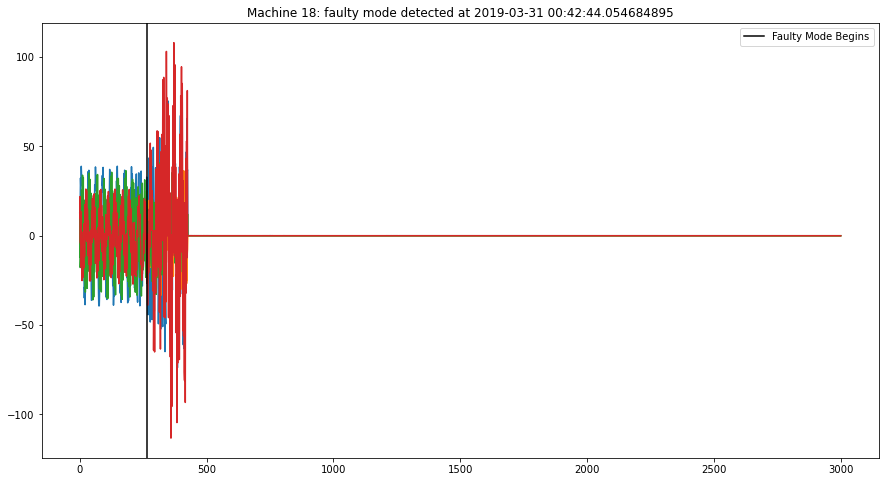

In [29]:
for p in range(19):
    data = pd.read_csv('../exampleco_data/machine_'+str(p)+'.csv',index_col=0)
    d = threshold_denoiser(data)
    f_val, timestamp = machine_faulty(d)
    fig = plt.figure(figsize=(15,8))
    plt.plot(range(len(d)), d[['0', '1', '2', '3']], figure = fig)
    if f_val:
        plt.axvline(f_val, color='k', label='Faulty Mode Begins')
    plt.title('Machine '+str(p)+': faulty mode detected at '+str(timestamp))
    plt.legend()
    plt.show()

#### Technical Explanation

The algorithm first removes noise by filtering out data points that exceed a threshold value determined through visual inspection. I took this approach because it was the most effective of those I tested at consistantly removing the noise across all the data sets provided. It also made sense that given the scenario there would a known range of expected values for each time series and a known range of values caused by communication errors that would enable a user/system monitor to set a manual threshold. However, this manually set threshold for noise is a definite limitation of my approach -- depending on how different other datasets are, it may prevent effective generalization. With more time for thorough testing I would explore other approaches of denoising the data such as a more through test of fourier transform as an approach as well as ARMA and ARIMA models.

Post-denoising the data, the algorithm exploits the fact that the faulty mode of the machines are characterized by a wider range of values within each time series before entering failure mode with values close to zero. This means that the standard deviation, as a measure of spread, will increase when the machine enters faulty mode. To flag this increase in standard deviation, the algorithm calculates the standard deviation of each time series over a five period rolling window. When the standard deviation calculated this way exceeds the mean of the previous standard deviations by one standard deviation (of the standard deviations) the algorithm flags for every time series the algorithm flags the machine as entering faulty mode. As a precaution it also notes if the standard deviation of every time series falls near zero as this indicates that the machine entered failure mode. The strenghts of this approach include that it's simple which keeping compute and upkeep costs low as well as allowing it to generalize. It also requires very little runway to start working -- it's effective with a rolling window of five periods -- which means that it doesn't require a large sample of data generated in normal mode before it's able to flag faulty mode. However it is limited in that it's not resilient to noise and the denoising technique it depends on is based on a static threshold. If I assumed a reasonably large sample of normal data for each machine I'd like to test both whether fitting traditional time series models (like ARMA and ARIMA) as well as density based clustering algorithms like DBSCAN and HDBSCAN would work effectively here.